In [8]:
import torch_geometric
torch_geometric.__version__

'1.7.0'

In [9]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            # When applying GAT with num heads > 1, one needs to modify the 
            # input and output dimension of the conv layers (self.convs),
            # to ensure that the input dim of the next layer is num heads
            # multiplied by the output dim of the previous layer.
            # HINT: In case you want to play with multiheads, you need to change the for-loop when builds up self.convs to be
            # self.convs.append(conv_model(hidden_dim * num_heads, hidden_dim)), 
            # and also the first nn.Linear(hidden_dim * num_heads, hidden_dim) in post-message-passing.
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
          
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [3]:
class GraphSage(MessagePassing):
    
    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):  
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = torch.nn.Linear(in_channels, out_channels, bias)
        self.lin_r = torch.nn.Linear(in_channels, out_channels, bias)

        ############################################################################
        # TODO: Your code here! 
        # Define the layers needed for the message and update functions below.
        # self.lin_l is the linear transformation that you apply to embedding 
        #            for central node.
        # self.lin_r is the linear transformation that you apply to aggregated 
        #            message from neighbors.
        # Our implementation is ~2 lines, but don't worry if you deviate from this.


        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        """"""

        out = None

        ############################################################################
        # TODO: Your code here! 
        # Implement message passing, as well as any post-processing (our update rule).
        # 1. First call propagate function to conduct the message passing.
        #    1.1 See there for more information: 
        #        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        #    1.2 We use the same representations for central (x_central) and 
        #        neighbor (x_neighbor) nodes, which means you'll pass x=(x, x) 
        #        to propagate.
        # 2. Update our node embedding with skip connection.
        # 3. If normalize is set, do L-2 normalization (defined in 
        #    torch.nn.functional)
        # Our implementation is ~5 lines, but don't worry if you deviate from this.
        embd = self.propagate(edge_index, x=x)
        out = self.lin_r(embd)
        out += self.lin_r(x[1])
        if self.normalize:
            out = F.normalize(out, p=2., dim=-1)
        ############################################################################

        return out

    def message(self, x_j):

        out = None

        ############################################################################
        # TODO: Your code here! 
        # Implement your message function here.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.

        out = x_j
        ############################################################################

        return out

    def aggregate(self, inputs, index, dim_size = None):

        # The axis along which to index number of nodes.
        node_dim = self.node_dim
        out = torch_scatter.scatter(inputs, index, dim=node_dim, dim_size=dim_size, reduce="mean")
        ############################################################################
        # TODO: Your code here! 
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter: 
        # https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter
        # Our implementation is ~1 lines, but don't worry if you deviate from this.


        ############################################################################

        return out


In [10]:
class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 2,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = torch.nn.Linear(in_channels, heads * out_channels, bias=False)
        self.lin_r = torch.nn.Linear(in_channels, heads * out_channels, bias=False)
        self.att_l = torch.nn.Parameter(torch.Tensor(1, heads, out_channels))
        self.att_r = torch.nn.Parameter(torch.Tensor(1, heads, out_channels))

        ############################################################################
        # TODO: Your code here! 
        # Define the layers needed for the message functions below.
        # self.lin_l is the linear transformation that you apply to embeddings 
        # BEFORE message passing.
        # Pay attention to dimensions of the linear layers, since we're using 
        # multi-head attention.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.


        ############################################################################

        # self.lin_r = self.lin_l

        ############################################################################
        # TODO: Your code here! 
        # Define the attention parameters \overrightarrow{a_l/r}^T in the above intro.
        # You have to deal with multi-head scenarios.
        # Use nn.Parameter instead of nn.Linear
        # Our implementation is ~2 lines, but don't worry if you deviate from this.


        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):
        
        H, C = self.heads, self.out_channels

        ############################################################################
        # TODO: Your code here! 
        # Implement message passing, as well as any pre- and post-processing (our update rule).
        # 1. First apply linear transformation to node embeddings, and split that 
        #    into multiple heads. We use the same representations for source and
        #    target nodes, but apply different linear weights (W_l and W_r)
        # 2. Calculate alpha vectors for central nodes (alpha_l) and neighbor nodes (alpha_r).
        # 3. Call propagate function to conduct the message passing. 
        #    3.1 Remember to pass alpha = (alpha_l, alpha_r) as a parameter.
        #    3.2 See there for more information: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        # 4. Transform the output back to the shape of N * d.
        # Our implementation is ~5 lines, but don't worry if you deviate from this.
        x_l = self.lin_l(x).view(-1, H, C)
        x_r = self.lin_r(x).view(-1, H, C)
        alpha_l = (x_l * self.att_l).sum(dim=-1)
        alpha_r = (x_r * self.att_r).sum(dim=-1)

        out = self.propagate(edge_index, x=(x_l, x_r),
                             alpha=(alpha_l, alpha_r), size=size).view(-1, H * C)
        ############################################################################
        return out


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):

        ############################################################################
        # TODO: Your code here! 
        # Implement your message function. Putting the attention in message 
        # instead of in update is a little tricky.
        # 1. Calculate the final attention weights using alpha_i and alpha_j,
        #    and apply leaky Relu.
        # 2. Calculate softmax over the neighbor nodes for all the nodes. Use 
        #    torch_geometric.utils.softmax instead of the one in Pytorch.
        # 3. Apply dropout to attention weights (alpha).
        # 4. Multiply embeddings and attention weights. As a sanity check, the output
        #    should be of shape E * H * d.
        # 5. ptr (LongTensor, optional): If given, computes the softmax based on
        #    sorted inputs in CSR representation. You can simply pass it to softmax.
        # Our implementation is ~5 lines, but don't worry if you deviate from this.
        alpha = alpha_j if alpha_i is None else alpha_j + alpha_i
        alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout)
        out = x_j * alpha.unsqueeze(-1)
        ############################################################################

        return out


    def aggregate(self, inputs, index, dim_size = None):
        ############################################################################
        # TODO: Your code here! 
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter: https://pytorch-scatter.readthedocs.io/en/latest/_modules/torch_scatter/scatter.html
        # Pay attention to "reduce" parameter is different from that in GraphSage.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.

        out = torch_scatter.scatter(inputs, index, dim_size=dim_size, dim=0)
        ############################################################################
    
        return out

In [11]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

In [6]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):
    
    print("Node task. test set size:", np.sum(dataset[0]['train_mask'].numpy()))
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, 
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          test_accs.append(test_acc)
        else:
          test_accs.append(test_accs[-1])
    return test_accs, losses

def test(loader, model, is_validation=True):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = data.y[mask]
            
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()
    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


Node task. test set size: 140
Maximum accuracy: 0.67
Minimum loss: 0.31748706102371216
Node task. test set size: 140
Maximum accuracy: 0.736
Minimum loss: 0.01938866823911667


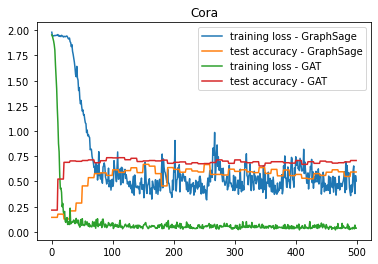

In [12]:
def main():
    for args in [
        {'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
    ]:
        args = objectview(args)
        for model in ['GraphSage', 'GAT']:
            args.model_type = model

            # Match the dimension.
            if model == 'GAT':
              args.heads = 2
            else:
              args.heads = 1

            if args.dataset == 'cora':
                dataset = Planetoid(root='/tmp/cora', name='Cora')
            else:
                raise NotImplementedError("Unknown dataset") 
            test_accs, losses = train(dataset, args) 

            print("Maximum accuracy: {0}".format(max(test_accs)))
            print("Minimum loss: {0}".format(min(losses)))

            plt.title(dataset.name)
            plt.plot(losses, label="training loss" + " - " + args.model_type)
            plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
        plt.legend()
        plt.show()

if __name__ == '__main__':
    main()

In [13]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

def visualize(G, color_map=None, seed=123):
  if color_map is None:
    color_map = '#c92506'
  plt.figure(figsize=(8, 8))
  nodes = nx.draw_networkx_nodes(G, pos=nx.spring_layout(G, seed=seed), \
                                 label=None, node_color=color_map, node_shape='o', node_size=150)
  edges = nx.draw_networkx_edges(G, pos=nx.spring_layout(G, seed=seed), alpha=0.5)
  if color_map is not None:
    plt.scatter([],[], c='#c92506', label='Nodes with label 0', edgecolors="black", s=140)
    plt.scatter([],[], c='#fcec00', label='Nodes with label 1', edgecolors="black", s=140)
    plt.legend(prop={'size': 13}, handletextpad=0)
  nodes.set_edgecolor('black')
  plt.show()

(0, {'node_feature': tensor([0.8713, 0.8979, 0.1256, 0.0882, 0.2460]), 'node_label': tensor(0)})


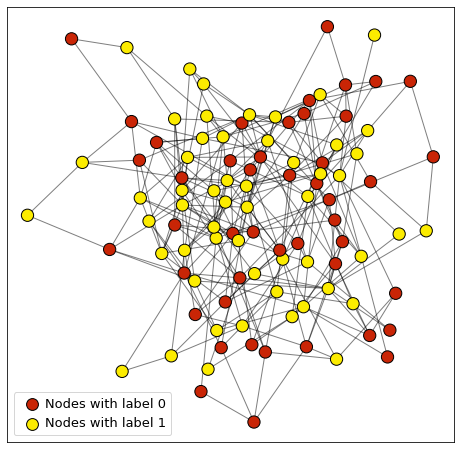

Graph(G=[], edge_index=[2, 524], edge_label_index=[2, 524], node_feature=[100, 5], node_label=[100], node_label_index=[100])
Node feature (node_feature) has shape torch.Size([100, 5]) and type torch.float32
Node label (node_label) has shape torch.Size([100]) and type torch.int64
Edge index (edge_index) has shape torch.Size([2, 524]) and type torch.int64
The DeepSNAP graph has <class 'networkx.classes.graph.Graph'> as the internal manupulation graph


In [16]:
num_nodes = 100
p = 0.05
seed = 100

# Generate a networkx random graph
G = nx.gnp_random_graph(num_nodes, p, seed=seed)

# Generate some random node features and labels
node_feature = {node : torch.rand([5, ]) for node in G.nodes()}
node_label = {node : torch.randint(0, 2, ()) for node in G.nodes()}
# print(node_feature)
# print(node_label)
# Set the random features and labels to G
nx.set_node_attributes(G, node_feature, name='node_feature')
nx.set_node_attributes(G, node_label, name='node_label')

# Print one node example
for node in G.nodes(data=True):
  print(node)
  break

color_map = ['#c92506' if node[1]['node_label'].item() == 0 else '#fcec00' for node in G.nodes(data=True)]

# Visualize the graph
visualize(G, color_map=color_map)

# Transform the networkx graph into the deepsnap graph
graph = Graph(G)

# Print out the general deepsnap graph information
print(graph)

# DeepSNAP will convert node attributes to tensors
# Notice the type of tensors
print("Node feature (node_feature) has shape {} and type {}".format(graph.node_feature.shape, graph.node_feature.dtype))
print("Node label (node_label) has shape {} and type {}".format(graph.node_label.shape, graph.node_label.dtype))

# DeepSNAP will also generate the edge_index tensor
print("Edge index (edge_index) has shape {} and type {}".format(graph.edge_index.shape, graph.edge_index.dtype))

# Different from only storing tensors, deepsnap graph also references to the networkx graph
# We will discuss why the reference will be helpful later
print("The DeepSNAP graph has {} as the internal manupulation graph".format(type(graph.G)))

In [17]:
# Number of nodes
print("The random graph has {} nodes".format(graph.num_nodes))

# Number of edges
print("The random graph has {} edges".format(graph.num_edges))

The random graph has 100 nodes
The random graph has 262 edges


In [18]:
root = './tmp/cora'
name = 'Cora'

# The Cora dataset
pyg_dataset= Planetoid(root, name)

# PyG dataset to a list of deepsnap graphs
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Get the first deepsnap graph (CORA only has one graph)
graph = graphs[0]
print(graph)

Processing...
Done!
Graph(G=[], edge_index=[2, 10556], edge_label_index=[2, 10556], node_feature=[2708, 1433], node_label=[2708], node_label_index=[2708])


In [24]:
def get_num_node_classes(graph):
  # TODO: Implement this function that takes a deepsnap graph object
  # and return the number of node classes of that graph.

  num_node_classes = 0

  ############# Your code here #############
  ## (~1 line of code)
  ## Note
  ## 1. Colab autocomplete functionality might be useful
  ## 2. DeepSNAP documentation might be useful https://snap.stanford.edu/deepsnap/modules/graph.html

  ##########################################
  print(graph.__dir__)
  return graph.get_num_labels("node_label")

def get_num_node_features(graph):
  # TODO: Implement this function that takes a deepsnap graph object
  # and return the number of node features of that graph.

  num_node_features = 0

  ############# Your code here #############
  ## (~1 line of code)
  ## Note
  ## 1. Colab autocomplete functionality might be useful
  ## 2. DeepSNAP documentation might be useful https://snap.stanford.edu/deepsnap/modules/graph.html


  ##########################################

  return graph.num_node_features

num_node_classes = get_num_node_classes(graph)
num_node_features = get_num_node_features(graph)
print("{} has {} classes".format(name, num_node_classes))
print("{} has {} features".format(name, num_node_features))

<built-in method __dir__ of Graph object at 0x7f8f7a6d9d60>
Cora has tensor([0, 1, 2, 3, 4, 5, 6]) classes
Cora has 1433 features


In [25]:
root = './tmp/cox2'
name = 'COX2'

# Load the dataset through PyG
pyg_dataset = TUDataset(root, name)

# Convert to a list of deepsnap graphs
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Convert list of deepsnap graphs to deepsnap dataset with specified task=graph
dataset = GraphDataset(graphs, task='graph')
print(dataset)

Extracting tmp/cox2/COX2/COX2.zip
Processing...
Done!
GraphDataset(467)


In [33]:
def get_graph_class(dataset, idx):
  # TODO: Implement this function that takes a deepsnap dataset object,
  # the index of the graph in the dataset, and returns the class/label 
  # of the graph (in integer).

  label = -1

  ############# Your code here ############
  ## (~1 line of code)
  ## Note
  ## 1. The label refers to the graph-level attribute


  #########################################

  return dataset[idx].get_num_labels("graph_label")

graph_0 = dataset[0]
print(graph_0)
idx = 100
print(dataset[100])
print(dataset[101])
label = get_graph_class(dataset, idx)
print('Graph with index {} has label {}'.format(idx, label))

Graph(G=[], edge_index=[2, 82], edge_label_index=[2, 82], graph_label=[1], node_feature=[39, 35], node_label_index=[39], task=[])
Graph(G=[], edge_index=[2, 78], edge_label_index=[2, 78], graph_label=[1], node_feature=[37, 35], node_label_index=[37], task=[])
Graph(G=[], edge_index=[2, 84], edge_label_index=[2, 84], graph_label=[1], node_feature=[40, 35], node_label_index=[40], task=[])
Graph with index 100 has label tensor([0])


In [35]:
def get_graph_num_edges(dataset, idx):
  # TODO: Implement this function that takes a deepsnap dataset object,
  # the index of the graph in dataset, and returns the number of 
  # edges in the graph (in integer).

  num_edges = 0

  ############# Your code here ############
  ## (~1 lines of code)
  ## Note
  ## 1. You can use the class property directly


  #########################################

  return dataset[idx].num_edges

print(dataset[200])
idx = 200
num_edges = get_graph_num_edges(dataset, idx)
print('Graph with index {} has {} edges'.format(idx, num_edges))

Graph(G=[], edge_index=[2, 98], edge_label_index=[2, 98], graph_label=[1], node_feature=[47, 35], node_label_index=[47], task=[])
Graph with index 200 has 49 edges


In [36]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

In [37]:
root = './tmp/cox2'
name = 'COX2'

pyg_dataset = TUDataset(root, name)

graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Here we specify the task as graph-level task such as graph classification
task = 'graph'
dataset = GraphDataset(graphs, task=task)

# Specify transductive=False (inductive)
dataset_train, dataset_val, dataset_test = dataset.split(transductive=False, split_ratio=[0.8, 0.1, 0.1])

print("COX2 train dataset: {}".format(dataset_train))
print("COX2 validation dataset: {}".format(dataset_val))
print("COX2 test dataset: {}".format(dataset_test))

COX2 train dataset: GraphDataset(373)
COX2 validation dataset: GraphDataset(46)
COX2 test dataset: GraphDataset(48)


In [38]:
root = './tmp/cora'
name = 'Cora'

pyg_dataset = Planetoid(root, name)

graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Here we specify the task as node-level task such as node classification
task = 'node'

dataset = GraphDataset(graphs, task=task)

# Specify we want the transductive splitting
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

print("Cora train dataset: {}".format(dataset_train))
print("Cora validation dataset: {}".format(dataset_val))
print("Cora test dataset: {}".format(dataset_test))

print("Original Cora has {} nodes".format(dataset.num_nodes[0]))

# The nodes in each set can be find in node_label_index
print("After the split, Cora has {} training nodes".format(dataset_train[0].node_label_index.shape[0]))
print("After the split, Cora has {} validation nodes".format(dataset_val[0].node_label_index.shape[0]))
print("After the split, Cora has {} test nodes".format(dataset_test[0].node_label_index.shape[0]))

Cora train dataset: GraphDataset(1)
Cora validation dataset: GraphDataset(1)
Cora test dataset: GraphDataset(1)
Original Cora has 2708 nodes
After the split, Cora has 2166 training nodes
After the split, Cora has 270 validation nodes
After the split, Cora has 272 test nodes


In [44]:
root = './tmp/cora'
name = 'Cora'

pyg_dataset = Planetoid(root, name)

graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Specify task as link_pred for edge-level task
task = 'link_pred'

# Specify the train mode, "all" mode is default for deepsnap dataset
edge_train_mode = "all"

dataset = GraphDataset(graphs, task=task, edge_train_mode=edge_train_mode)

# Transductive link prediction split
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

print("Cora train dataset: {}".format(dataset_train))
print("Cora validation dataset: {}".format(dataset_val))
print("Cora test dataset: {}".format(dataset_test))

Cora train dataset: GraphDataset(1)
Cora validation dataset: GraphDataset(1)
Cora test dataset: GraphDataset(1)


In [48]:
root = './tmp/cora'
name = 'Cora'

pyg_dataset = Planetoid(root, name)

graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Specify task as link_pred for edge-level task
task = 'link_pred'

# Specify the train mode, "all" mode is default for deepsnap dataset
edge_train_mode = "all"

dataset = GraphDataset(graphs, task=task, edge_train_mode=edge_train_mode)
print(graphs)
# Transductive link prediction split
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

print("Cora train dataset: {}".format(dataset_train))
print("Cora validation dataset: {}".format(dataset_val))
print("Cora test dataset: {}".format(dataset_test))

[Graph(G=[], edge_index=[2, 10556], edge_label_index=[2, 10556], negative_label_val=[1], node_feature=[2708, 1433], node_label=[2708], node_label_index=[2708], task=[])]
Cora train dataset: GraphDataset(1)
Cora validation dataset: GraphDataset(1)
Cora test dataset: GraphDataset(1)


In [49]:
print("Original Cora graph has {} edges".format(dataset[0].num_edges))
print("Because Cora graph is undirected, the original edge_index has shape {}".format(dataset[0].edge_index.shape))

print("The training set has message passing edge index shape {}".format(dataset_train[0].edge_index.shape))
print("The training set has supervision edge index shape {}".format(dataset_train[0].edge_label_index.shape))

print("The validation set has message passing edge index shape {}".format(dataset_val[0].edge_index.shape))
print("The validation set has supervision edge index shape {}".format(dataset_val[0].edge_label_index.shape))

print("The test set has message passing edge index shape {}".format(dataset_test[0].edge_index.shape))
print("The test set has supervision edge index shape {}".format(dataset_test[0].edge_label_index.shape))

Original Cora graph has 5278 edges
Because Cora graph is undirected, the original edge_index has shape torch.Size([2, 10556])
The training set has message passing edge index shape torch.Size([2, 8444])
The training set has supervision edge index shape torch.Size([2, 16888])
The validation set has message passing edge index shape torch.Size([2, 8444])
The validation set has supervision edge index shape torch.Size([2, 2108])
The test set has message passing edge index shape torch.Size([2, 9498])
The test set has supervision edge index shape torch.Size([2, 2116])


In [144]:
def edge_indices_disjoint(edge_index_1, edge_index_2):
  # TODO: Implement this function that takes two edge index tensors,
  # and returns whether these two edge index tensors are disjoint.
  disjoint = None
  ############# Your code here ############
  ## (~5 lines of code)
  ## Note
  ## 1. Here disjoint means that there is no single edge belongs to either edge index tensors
  ## 2. You do not need to consider the undirected case. For example, if edge_index_1 contains
  ## edge (a, b) and edge_index_2 contains edge (b, a). We will treat them as disjoint in this
  ## function.
  m1 = torch.max(edge_index_1).numpy()
  m2 = torch.max(edge_index_2).numpy()
  m = max(m1, m2)
  e1 = edge_index_1[1] * m + edge_index_1[0]
  e2 = edge_index_2[1] * m + edge_index_2[0]
  i = np.intersect1d(e1, e2)
  if i.size == 0:
      disjoint = True
  else:
      disjoint = False
  #########################################

  return disjoint

In [145]:
num_train_edges = dataset_train[0].edge_label_index.shape[1] // 2
train_pos_edge_index = dataset_train[0].edge_label_index[:, :num_train_edges]
train_neg_edge_index = dataset_train[0].edge_label_index[:, num_train_edges:]
print("3.1 Training (supervision) positve and negative edges are disjoint = {}"\
        .format(edge_indices_disjoint(train_pos_edge_index, train_neg_edge_index)))

num_val_edges = dataset_val[0].edge_label_index.shape[1] // 2
val_pos_edge_index = dataset_val[0].edge_label_index[:, :num_val_edges]
val_neg_edge_index = dataset_val[0].edge_label_index[:, num_val_edges:]
print("3.2 Validation (supervision) positve and negative edges are disjoint = {}"\
        .format(edge_indices_disjoint(val_pos_edge_index, val_neg_edge_index)))

num_test_edges = dataset_test[0].edge_label_index.shape[1] // 2
test_pos_edge_index = dataset_test[0].edge_label_index[:, :num_test_edges]
test_neg_edge_index = dataset_test[0].edge_label_index[:, num_test_edges:]
print("3.3 Test (supervision) positve and negative edges are disjoint = {}"\
        .format(edge_indices_disjoint(test_pos_edge_index, test_neg_edge_index)))

print("3.4 Test (supervision) positve and validation (supervision) positve edges are disjoint = {}"\
        .format(edge_indices_disjoint(test_pos_edge_index, val_pos_edge_index)))
print("3.5 Validation (supervision) positve and training (supervision) positve edges are disjoint = {}"\
        .format(edge_indices_disjoint(val_pos_edge_index, train_pos_edge_index)))

3.1 Training (supervision) positve and negative edges are disjoint = True
3.2 Validation (supervision) positve and negative edges are disjoint = True
3.3 Test (supervision) positve and negative edges are disjoint = True
3.4 Test (supervision) positve and validation (supervision) positve edges are disjoint = True
3.5 Validation (supervision) positve and training (supervision) positve edges are disjoint = True


In [146]:
edge_train_mode = "disjoint"

dataset = GraphDataset(graphs, task='link_pred', edge_train_mode=edge_train_mode)
orig_edge_index = dataset[0].edge_index
dataset_train, dataset_val, dataset_test = dataset.split(
    transductive=True, split_ratio=[0.8, 0.1, 0.1])

train_message_edge_index = dataset_train[0].edge_index
train_sup_edge_index = dataset_train[0].edge_label_index
val_sup_edge_index = dataset_val[0].edge_label_index
test_sup_edge_index = dataset_test[0].edge_label_index

print("The edge index of original graph has shape: {}".format(orig_edge_index.shape))
print("The edge index of training message edges has shape: {}".format(train_message_edge_index.shape))
print("The edge index of training supervision edges has shape: {}".format(train_sup_edge_index.shape))
print("The edge index of validation message edges has shape: {}".format(dataset_val[0].edge_index.shape))
print("The edge index of validation supervision edges has shape: {}".format(val_sup_edge_index.shape))
print("The edge index of test message edges has shape: {}".format(dataset_test[0].edge_index.shape))
print("The edge index of test supervision edges has shape: {}".format(test_sup_edge_index.shape))

The edge index of original graph has shape: torch.Size([2, 10556])
The edge index of training message edges has shape: torch.Size([2, 6754])
The edge index of training supervision edges has shape: torch.Size([2, 3380])
The edge index of validation message edges has shape: torch.Size([2, 8444])
The edge index of validation supervision edges has shape: torch.Size([2, 2108])
The edge index of test message edges has shape: torch.Size([2, 9498])
The edge index of test supervision edges has shape: torch.Size([2, 2116])


In [147]:
dataset = GraphDataset(graphs, task='link_pred', edge_train_mode="disjoint")
datasets = {}
follow_batch = []
datasets['train'], datasets['val'], datasets['test'] = dataset.split(
    transductive=True, split_ratio=[0.8, 0.1, 0.1])
dataloaders = {
  split: DataLoader(
    ds, collate_fn=Batch.collate(follow_batch),
    batch_size=1, shuffle=(split=='train')
  )
  for split, ds in datasets.items()
}
neg_edges_1 = None
for batch in dataloaders['train']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_1 = batch.edge_label_index[:, num_edges:]
  print("First iteration training negative edges:")
  print(neg_edges_1)
  break
neg_edges_2 = None
for batch in dataloaders['train']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_2 = batch.edge_label_index[:, num_edges:]
  print("Second iteration training negative edges:")
  print(neg_edges_2)
  break

neg_edges_1 = None
for batch in dataloaders['val']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_1 = batch.edge_label_index[:, num_edges:]
  print("First iteration validation negative edges:")
  print(neg_edges_1)
  break
neg_edges_2 = None
for batch in dataloaders['val']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_2 = batch.edge_label_index[:, num_edges:]
  print("Second iteration validation negative edges:")
  print(neg_edges_2)
  break

First iteration training negative edges:
tensor([[ 806, 2143,  680,  ..., 1877, 1719, 1052],
        [2123, 1634, 2365,  ..., 1849,  488, 2431]])
Second iteration training negative edges:
tensor([[ 541, 1042,  573,  ...,  234, 1340,  755],
        [ 222, 1249, 2222,  ...,  384, 1435,  335]])
First iteration validation negative edges:
tensor([[ 655, 1435,   36,  ..., 1180, 1790, 1458],
        [ 338, 1089, 1089,  ...,  189,  215, 2291]])
Second iteration validation negative edges:
tensor([[ 655, 1435,   36,  ..., 1180, 1790, 1458],
        [ 338, 1089, 1089,  ...,  189,  215, 2291]])


In [148]:
def pagerank_transform_fn(graph):

  # Get the referenced networkx graph
  G = graph.G

  # Calculate the pagerank by using networkx
  pr = nx.pagerank(G)

  # Transform the pagerank values to tensor
  pr_feature = torch.tensor([pr[node] for node in range(graph.num_nodes)], dtype=torch.float32)
  pr_feature = pr_feature.view(graph.num_nodes, 1)

  # Concat the pagerank values to the node feature
  graph.node_feature = torch.cat([graph.node_feature, pr_feature], dim=-1)

root = './tmp/cox2'
name = 'COX2'
pyg_dataset = TUDataset(root, name)
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
dataset = GraphDataset(graphs, task='graph')
print("Number of features before transformation: {}".format(dataset.num_node_features))
dataset.apply_transform(pagerank_transform_fn, update_tensor=False)
print("Number of features after transformation: {}".format(dataset.num_node_features))

Number of features before transformation: 35
Number of features after transformation: 36


In [151]:
def cluster_transform_fn(graph):
  # TODO: Implement this function that takes an deepsnap graph object,
  # transform the graph by adding nodes clustering coefficient into the 
  # graph.node_feature

  ############# Your code here ############
  ## (~5 lines of code)
  ## Note
  ## 1. Compute the clustering coefficient value for each node and
  ## concat them to the last dimension of graph.node_feature

  # Get the referenced networkx graph
  G = graph.G

  # Calculate the pagerank by using networkx
  pr = nx.clustering(G)

  # Transform the pagerank values to tensor
  pr_feature = torch.tensor([pr[node] for node in range(graph.num_nodes)], dtype=torch.float32)
  pr_feature = pr_feature.view(graph.num_nodes, 1)

  # Concat the pagerank values to the node feature
  graph.node_feature = torch.cat([graph.node_feature, pr_feature], dim=-1)
  #########################################

root = './cox2'
name = 'COX2'
pyg_dataset = TUDataset(root, name)
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
dataset = GraphDataset(graphs, task='graph')
print("Number of features before transformation: {}".format(dataset.num_node_features))

# Transform the dataset
dataset.apply_transform(cluster_transform_fn, update_tensor=False)
print("Number of features before transformation: {}".format(dataset.num_node_features))

node_idx = 3
graph_idx = 406
node_feature = dataset[graph_idx].node_feature

print("The node has clustering coefficient: {}".format(round(node_feature[node_idx][-1].item(), 2)))

Number of features before transformation: 35
Number of features before transformation: 36
The node has clustering coefficient: 0.17


In [247]:
import copy
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class LinkPredModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.2):
        super(LinkPredModel, self).__init__()

        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, num_classes)

        self.loss_fn = nn.BCEWithLogitsLoss()

        ############# Your code here #############
        ## (~1 line of code)
        ## Note
        ## 1. Initialize the loss function to BCEWithLogitsLoss


        ##########################################

        self.dropout = dropout

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, batch):
        node_feature, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
        
        ############# Your code here #############
        ## (~6 line of code)
        ## Note
        ## 1. Feed the node feature into the first conv layer
        ## 2. Add a ReLU after the first conv layer
        ## 3. Add dropout after the ReLU (with probability self.dropout)
        ## 4. Feed the output to the second conv layer
        ## 5. Select the embeddings of the source nodes and destination nodes
        ## by using the edge_label_index and compute the similarity of each pair
        ## by dot product

        x = self.conv1(node_feature, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout)
        x = self.conv2(x, edge_index)
        pred = torch.sum(x[edge_label_index[0]] * x[edge_label_index[1]], dim=-1)
        ##########################################

        return pred
    
    def loss(self, pred, link_label):
        return self.loss_fn(pred, link_label)

In [248]:
from sklearn.metrics import *

def train(model, dataloaders, optimizer, args):
    val_max = 0
    best_model = model

    for epoch in range(1, args["epochs"]):
        for i, batch in enumerate(dataloaders['train']):
            
            batch.to(args["device"])

            ############# Your code here #############
            ## (~6 lines of code)
            ## Note
            ## 1. Zero grad the optimizer
            ## 2. Compute loss and backpropagate
            ## 3. Update the model parameters
            optimizer.zero_grad()
            pred = model(batch)
            num_edges = batch.edge_label_index.shape[1] // 2
            label = torch.ones(batch.edge_label_index.shape[1], dtype=float)
            neg_edge = batch.edge_label_index[:, num_edges:]
            label[neg_edge] = 0.0
            loss = model.loss(pred, label)
            loss.backward()
            optimizer.step()
            ##########################################

            log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}, Loss: {}'
            score_train = test(model, dataloaders['train'], args)
            score_val = test(model, dataloaders['val'], args)
            score_test = test(model, dataloaders['test'], args)

            print(log.format(epoch, score_train, score_val, score_test, loss.item()))
            if val_max < score_val:
                val_max = score_val
                best_model = copy.deepcopy(model)
    return best_model

def test(model, dataloader, args):
    model.eval()

    score = 0

    ############# Your code here #############
    ## (~5 lines of code)
    ## Note
    ## 1. Loop through batches in the dataloader
    ## 2. Feed the batch to the model
    ## 3. Feed the model output to sigmoid
    ## 4. Compute the ROC-AUC score by using sklearn roc_auc_score function
    ## 5. Edge labels are stored in batch.edge_label

    
    ##########################################
 
    return score

In [249]:
# Please don't change any parameters
args = {
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_dim" : 128,
    "epochs" : 200,
}

In [250]:
pyg_dataset = Planetoid('./tmp/cora', 'Cora')
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

dataset = GraphDataset(
        graphs,
        task='link_pred',
        edge_train_mode="disjoint"
    )
datasets = {}
datasets['train'], datasets['val'], datasets['test']= dataset.split(
            transductive=True, split_ratio=[0.85, 0.05, 0.1])
input_dim = datasets['train'].num_node_features
num_classes = datasets['train'].num_edge_labels

model = LinkPredModel(input_dim, args["hidden_dim"], num_classes).to(args["device"])
model.reset_parameters()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

dataloaders = {split: DataLoader(
            ds, collate_fn=Batch.collate([]),
            batch_size=1, shuffle=(split=='train'))
            for split, ds in datasets.items()}
best_model = train(model, dataloaders, optimizer, args)
log = "Train: {:.4f}, Val: {:.4f}, Test: {:.4f}"
best_train_roc = test(best_model, dataloaders['train'], args)
best_val_roc = test(best_model, dataloaders['val'], args)
best_test_roc = test(best_model, dataloaders['test'], args)
print(log.format(best_train_roc, best_val_roc, best_test_roc))

Epoch: 001, Train: 0.0000, Val: 0.0000, Test: 0.0000, Loss: 0.6934967759935728
Epoch: 002, Train: 0.0000, Val: 0.0000, Test: 0.0000, Loss: 0.6935022045806731
Epoch: 003, Train: 0.0000, Val: 0.0000, Test: 0.0000, Loss: 0.6934461138763894
Epoch: 004, Train: 0.0000, Val: 0.0000, Test: 0.0000, Loss: 0.6933792605954394
Epoch: 005, Train: 0.0000, Val: 0.0000, Test: 0.0000, Loss: 0.6933998655391327
Epoch: 006, Train: 0.0000, Val: 0.0000, Test: 0.0000, Loss: 0.6933294659800033
Epoch: 007, Train: 0.0000, Val: 0.0000, Test: 0.0000, Loss: 0.6933704873664234
Epoch: 008, Train: 0.0000, Val: 0.0000, Test: 0.0000, Loss: 0.693271510746625
Epoch: 009, Train: 0.0000, Val: 0.0000, Test: 0.0000, Loss: 0.6933035749594331
Epoch: 010, Train: 0.0000, Val: 0.0000, Test: 0.0000, Loss: 0.693241690337819
Epoch: 011, Train: 0.0000, Val: 0.0000, Test: 0.0000, Loss: 0.6932187615697455
Epoch: 012, Train: 0.0000, Val: 0.0000, Test: 0.0000, Loss: 0.6932074523479634
Epoch: 013, Train: 0.0000, Val: 0.0000, Test: 0.0000, 